In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=150 # Number of kernels in convolutional network
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
val_rate=0.2
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
# Reshape the coordinates, in order to apply convolutional operation
x = total_coords.reshape((16*9, 2, 55, 1))

In [22]:
# Input of parameters
# These variables are put into the network after convolution and flattening
x_para = np.hstack((aa, hh, bb))

In [23]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [24]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [25]:
cd_orig = target_df.iloc[:,3].values # Cd values
#target_c4 = target_df.iloc[:,4].values# Cl values

In [26]:
cd = (cd_orig-np.min(cd_orig))/(np.max(cd_orig)-np.min(cd_orig))

In [27]:
y = cd.reshape((-1,1))

In [28]:
y.shape

(144, 1)

In [29]:
x_para_all, x_para_test, x_all, x_test, y_all, y_test = train_test_split(x_para, x, y, test_size=test_rate, random_state=1)

In [30]:
x_para_train, x_para_val, x_train, x_val, y_train, y_val = train_test_split(x_para_all, x_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [31]:
tf.keras.backend.set_image_data_format('channels_last')

In [32]:
input_1 = tf.keras.Input(shape=(2,55,1))
input_2 = tf.keras.Input(shape=(3))

x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1, padding='same',
                                 activation='relu', name='convLayer')(input_1)
x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)

x_flat = tf.keras.layers.Flatten()(x_pool)
x_concat = tf.keras.layers.Concatenate()([x_flat, input_2])

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_concat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# AeroCNN-I
model = tf.keras.Model([input_1, input_2], output_data)

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 150)   750         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 150)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 4050)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [35]:
model_directory = "D:\\TrainedModels\\20221205"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [36]:
ckpt_name = model_directory + "20221205steadyValidation_AeroCNN1_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" + str(n_units) +"units_OptimalSettings_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-09, min_lr=1e-06, verbose=1)

In [37]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [38]:
start = datetime.datetime.now()
history = model.fit([x_train, x_para_train], y_train, batch_size=batch_size,
                    validation_data=([x_val, x_para_val], y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/5 [=====>........................] - ETA: 9s - loss: 0.1378 - rmse: 0.3712
Epoch 1: val_loss improved from inf to 0.08770, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 3s 89ms/step - loss: 0.1298 - rmse: 0.3602 - val_loss: 0.0877 - val_rmse: 0.2961 - lr: 1.0000e-04
Epoch 2/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.1013 - rmse: 0.3182
Epoch 2: val_loss improved from 0.08770 to 0.07679, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 32ms/step - loss: 0.1180 - rmse: 0.3435 - val_loss: 0.0768 - val_rmse: 0.2771 - lr: 1.0000e-04
Epoch 3/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0964 - rmse: 0.3104
Epoch 3: val_loss improved from 0.07679 to 0.06404, saving model to D:\TrainedModels\20221205

Epoch 22/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0392 - rmse: 0.1981
Epoch 22: val_loss improved from 0.02177 to 0.02121, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 29ms/step - loss: 0.0386 - rmse: 0.1965 - val_loss: 0.0212 - val_rmse: 0.1456 - lr: 1.0000e-04
Epoch 23/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0449 - rmse: 0.2120
Epoch 23: val_loss improved from 0.02121 to 0.01881, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 29ms/step - loss: 0.0356 - rmse: 0.1886 - val_loss: 0.0188 - val_rmse: 0.1372 - lr: 1.0000e-04
Epoch 24/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0262 - rmse: 0.1619
Epoch 24: val_loss improved from 0.01881 to 0.01730, saving model to D:\TrainedModel

Epoch 45/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 45: val_loss did not improve from 0.00596
5/5 [==============================] - 0s 14ms/step - loss: 0.0070 - rmse: 0.0838 - val_loss: 0.0063 - val_rmse: 0.0792 - lr: 1.0000e-04
Epoch 46/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0380
Epoch 46: val_loss improved from 0.00596 to 0.00548, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 38ms/step - loss: 0.0067 - rmse: 0.0817 - val_loss: 0.0055 - val_rmse: 0.0740 - lr: 1.0000e-04
Epoch 47/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0087 - rmse: 0.0934
Epoch 47: val_loss improved from 0.00548 to 0.00532, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================]

1/5 [=====>........................] - ETA: 0s - loss: 0.0033 - rmse: 0.0573
Epoch 69: val_loss improved from 0.00398 to 0.00395, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 38ms/step - loss: 0.0041 - rmse: 0.0637 - val_loss: 0.0039 - val_rmse: 0.0628 - lr: 1.0000e-04
Epoch 70/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0558
Epoch 70: val_loss did not improve from 0.00395
5/5 [==============================] - 0s 14ms/step - loss: 0.0040 - rmse: 0.0629 - val_loss: 0.0046 - val_rmse: 0.0675 - lr: 1.0000e-04
Epoch 71/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0032 - rmse: 0.0561
Epoch 71: val_loss did not improve from 0.00395
5/5 [==============================] - 0s 15ms/step - loss: 0.0037 - rmse: 0.0612 - val_loss: 0.0040 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 72/10000
1/5 [=====>.......................

1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0366
Epoch 96: val_loss did not improve from 0.00353
5/5 [==============================] - 0s 14ms/step - loss: 0.0039 - rmse: 0.0623 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 1.0000e-04
Epoch 97/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0047 - rmse: 0.0683
Epoch 97: val_loss did not improve from 0.00353
5/5 [==============================] - 0s 14ms/step - loss: 0.0036 - rmse: 0.0602 - val_loss: 0.0040 - val_rmse: 0.0629 - lr: 1.0000e-04
Epoch 98/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0459
Epoch 98: val_loss did not improve from 0.00353
5/5 [==============================] - 0s 14ms/step - loss: 0.0031 - rmse: 0.0556 - val_loss: 0.0035 - val_rmse: 0.0594 - lr: 1.0000e-04
Epoch 99/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0028 - rmse: 0.0526
Epoch 99: val_loss did not improve from 0.00353
5/5 [==============================] - 0s 14

1/5 [=====>........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 122: val_loss improved from 0.00317 to 0.00314, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 32ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0031 - val_rmse: 0.0560 - lr: 1.0000e-04
Epoch 123/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0343
Epoch 123: val_loss did not improve from 0.00314
5/5 [==============================] - 0s 14ms/step - loss: 0.0030 - rmse: 0.0549 - val_loss: 0.0032 - val_rmse: 0.0570 - lr: 1.0000e-04
Epoch 124/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0036 - rmse: 0.0602
Epoch 124: val_loss did not improve from 0.00314
5/5 [==============================] - 0s 14ms/step - loss: 0.0036 - rmse: 0.0602 - val_loss: 0.0033 - val_rmse: 0.0573 - lr: 1.0000e-04
Epoch 125/10000
1/5 [=====>.................

5/5 [==============================] - 0s 42ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0030 - val_rmse: 0.0548 - lr: 1.0000e-04
Epoch 150/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0344
Epoch 150: val_loss did not improve from 0.00300
5/5 [==============================] - 0s 15ms/step - loss: 0.0026 - rmse: 0.0512 - val_loss: 0.0030 - val_rmse: 0.0550 - lr: 1.0000e-04
Epoch 151/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0027 - rmse: 0.0519
Epoch 151: val_loss did not improve from 0.00300
5/5 [==============================] - 0s 15ms/step - loss: 0.0024 - rmse: 0.0495 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 152/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0371
Epoch 152: val_loss did not improve from 0.00300
5/5 [==============================] - 0s 15ms/step - loss: 0.0025 - rmse: 0.0498 - val_loss: 0.0033 - val_rmse: 0.0578 - lr: 1.0000e-04
Epoch 153/10000
1/5 [=====

5/5 [==============================] - 0s 15ms/step - loss: 0.0043 - rmse: 0.0656 - val_loss: 0.0044 - val_rmse: 0.0664 - lr: 1.0000e-04
Epoch 179/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0053 - rmse: 0.0727
Epoch 179: val_loss did not improve from 0.00300
5/5 [==============================] - 0s 14ms/step - loss: 0.0033 - rmse: 0.0578 - val_loss: 0.0049 - val_rmse: 0.0702 - lr: 1.0000e-04
Epoch 180/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0053 - rmse: 0.0731
Epoch 180: val_loss did not improve from 0.00300
5/5 [==============================] - 0s 15ms/step - loss: 0.0031 - rmse: 0.0555 - val_loss: 0.0034 - val_rmse: 0.0580 - lr: 1.0000e-04
Epoch 181/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0512
Epoch 181: val_loss did not improve from 0.00300
5/5 [==============================] - 0s 14ms/step - loss: 0.0028 - rmse: 0.0529 - val_loss: 0.0035 - val_rmse: 0.0590 - lr: 1.0000e-04
Epoch 182/10000
1/5 [=====

5/5 [==============================] - 0s 14ms/step - loss: 0.0023 - rmse: 0.0480 - val_loss: 0.0031 - val_rmse: 0.0560 - lr: 1.0000e-04
Epoch 207/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0390
Epoch 207: val_loss did not improve from 0.00281
5/5 [==============================] - 0s 14ms/step - loss: 0.0021 - rmse: 0.0459 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e-04
Epoch 208/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0334
Epoch 208: val_loss did not improve from 0.00281
5/5 [==============================] - 0s 14ms/step - loss: 0.0023 - rmse: 0.0478 - val_loss: 0.0032 - val_rmse: 0.0569 - lr: 1.0000e-04
Epoch 209/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0483
Epoch 209: val_loss did not improve from 0.00281
5/5 [==============================] - 0s 14ms/step - loss: 0.0024 - rmse: 0.0492 - val_loss: 0.0028 - val_rmse: 0.0533 - lr: 1.0000e-04
Epoch 210/10000
1/5 [=====

5/5 [==============================] - 0s 15ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.0029 - val_rmse: 0.0540 - lr: 1.0000e-04
Epoch 236/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0397
Epoch 236: val_loss did not improve from 0.00279
5/5 [==============================] - 0s 14ms/step - loss: 0.0021 - rmse: 0.0454 - val_loss: 0.0029 - val_rmse: 0.0535 - lr: 1.0000e-04
Epoch 237/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0336
Epoch 237: val_loss did not improve from 0.00279
5/5 [==============================] - 0s 14ms/step - loss: 0.0021 - rmse: 0.0460 - val_loss: 0.0029 - val_rmse: 0.0541 - lr: 1.0000e-04
Epoch 238/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0033 - rmse: 0.0578
Epoch 238: val_loss did not improve from 0.00279
5/5 [==============================] - 0s 14ms/step - loss: 0.0020 - rmse: 0.0450 - val_loss: 0.0029 - val_rmse: 0.0540 - lr: 1.0000e-04
Epoch 239/10000
1/5 [=====

Epoch 264/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 264: val_loss did not improve from 0.00268
5/5 [==============================] - 0s 14ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0028 - val_rmse: 0.0534 - lr: 1.0000e-04
Epoch 265/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0394
Epoch 265: val_loss did not improve from 0.00268
5/5 [==============================] - 0s 14ms/step - loss: 0.0019 - rmse: 0.0439 - val_loss: 0.0027 - val_rmse: 0.0523 - lr: 1.0000e-04
Epoch 266/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0038 - rmse: 0.0620
Epoch 266: val_loss did not improve from 0.00268
5/5 [==============================] - 0s 14ms/step - loss: 0.0020 - rmse: 0.0449 - val_loss: 0.0028 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 267/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0317
Epoch 267: val_loss did not improve from 0.00268
5/5 [================

1/5 [=====>........................] - ETA: 0s - loss: 0.0031 - rmse: 0.0556
Epoch 291: val_loss did not improve from 0.00261
5/5 [==============================] - 0s 15ms/step - loss: 0.0021 - rmse: 0.0460 - val_loss: 0.0029 - val_rmse: 0.0535 - lr: 1.0000e-04
Epoch 292/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0367
Epoch 292: val_loss did not improve from 0.00261
5/5 [==============================] - 0s 15ms/step - loss: 0.0024 - rmse: 0.0494 - val_loss: 0.0040 - val_rmse: 0.0636 - lr: 1.0000e-04
Epoch 293/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0021 - rmse: 0.0461
Epoch 293: val_loss did not improve from 0.00261
5/5 [==============================] - 0s 14ms/step - loss: 0.0021 - rmse: 0.0461 - val_loss: 0.0028 - val_rmse: 0.0529 - lr: 1.0000e-04
Epoch 294/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0375
Epoch 294: val_loss did not improve from 0.00261
5/5 [==============================] 

5/5 [==============================] - 0s 34ms/step - loss: 0.0018 - rmse: 0.0418 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-04
Epoch 320/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0023 - rmse: 0.0482
Epoch 320: val_loss did not improve from 0.00246
5/5 [==============================] - 0s 15ms/step - loss: 0.0018 - rmse: 0.0419 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 1.0000e-04
Epoch 321/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.2727e-04 - rmse: 0.0270
Epoch 321: val_loss did not improve from 0.00246
5/5 [==============================] - 0s 14ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0026 - val_rmse: 0.0506 - lr: 1.0000e-04
Epoch 322/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0361
Epoch 322: val_loss improved from 0.00246 to 0.00243, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [===================

1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0326
Epoch 347: val_loss did not improve from 0.00237
5/5 [==============================] - 0s 15ms/step - loss: 0.0019 - rmse: 0.0432 - val_loss: 0.0024 - val_rmse: 0.0493 - lr: 1.0000e-04
Epoch 348/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0335
Epoch 348: val_loss did not improve from 0.00237
5/5 [==============================] - 0s 15ms/step - loss: 0.0016 - rmse: 0.0395 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 349/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.6484e-04 - rmse: 0.0311
Epoch 349: val_loss did not improve from 0.00237
5/5 [==============================] - 0s 15ms/step - loss: 0.0013 - rmse: 0.0366 - val_loss: 0.0025 - val_rmse: 0.0503 - lr: 1.0000e-04
Epoch 350/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 350: val_loss did not improve from 0.00237
5/5 [============================

5/5 [==============================] - 0s 42ms/step - loss: 0.0012 - rmse: 0.0347 - val_loss: 0.0022 - val_rmse: 0.0474 - lr: 1.0000e-04
Epoch 375/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0433
Epoch 375: val_loss did not improve from 0.00225
5/5 [==============================] - 0s 15ms/step - loss: 0.0012 - rmse: 0.0349 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-04
Epoch 376/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0027 - rmse: 0.0522
Epoch 376: val_loss did not improve from 0.00225
5/5 [==============================] - 0s 14ms/step - loss: 0.0015 - rmse: 0.0389 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 1.0000e-04
Epoch 377/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3384e-04 - rmse: 0.0306
Epoch 377: val_loss did not improve from 0.00225
5/5 [==============================] - 0s 14ms/step - loss: 0.0016 - rmse: 0.0399 - val_loss: 0.0034 - val_rmse: 0.0580 - lr: 1.0000e-04
Epoch 378/10000
1/5 [=

1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0361
Epoch 402: val_loss did not improve from 0.00206
5/5 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0327 - val_loss: 0.0021 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 403/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6520e-04 - rmse: 0.0163
Epoch 403: val_loss did not improve from 0.00206
5/5 [==============================] - 0s 14ms/step - loss: 0.0010 - rmse: 0.0317 - val_loss: 0.0021 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 404/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0019 - rmse: 0.0434
Epoch 404: val_loss did not improve from 0.00206
5/5 [==============================] - 0s 14ms/step - loss: 9.8230e-04 - rmse: 0.0313 - val_loss: 0.0024 - val_rmse: 0.0491 - lr: 1.0000e-04
Epoch 405/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7856e-04 - rmse: 0.0241
Epoch 405: val_loss improved from 0.00206 to 0.00204, saving model to D:\T

1/5 [=====>........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0374
Epoch 430: val_loss did not improve from 0.00201
5/5 [==============================] - 0s 14ms/step - loss: 0.0010 - rmse: 0.0319 - val_loss: 0.0021 - val_rmse: 0.0460 - lr: 1.0000e-04
Epoch 431/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 431: val_loss improved from 0.00201 to 0.00198, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 38ms/step - loss: 0.0010 - rmse: 0.0318 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 432/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0387
Epoch 432: val_loss did not improve from 0.00198
5/5 [==============================] - 0s 14ms/step - loss: 8.9776e-04 - rmse: 0.0300 - val_loss: 0.0020 - val_rmse: 0.0448 - lr: 1.0000e-04
Epoch 433/10000
1/5 [=====>.............

5/5 [==============================] - 0s 43ms/step - loss: 8.5950e-04 - rmse: 0.0293 - val_loss: 0.0018 - val_rmse: 0.0423 - lr: 1.0000e-04
Epoch 457/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5027e-04 - rmse: 0.0123
Epoch 457: val_loss did not improve from 0.00179
5/5 [==============================] - 0s 14ms/step - loss: 8.4391e-04 - rmse: 0.0291 - val_loss: 0.0021 - val_rmse: 0.0459 - lr: 1.0000e-04
Epoch 458/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0278e-04 - rmse: 0.0201
Epoch 458: val_loss improved from 0.00179 to 0.00176, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 39ms/step - loss: 8.4925e-04 - rmse: 0.0291 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 459/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7873e-04 - rmse: 0.0195
Epoch 459: val_loss did not improve from 0.00176
5/5 

5/5 [==============================] - 0s 15ms/step - loss: 7.3704e-04 - rmse: 0.0271 - val_loss: 0.0016 - val_rmse: 0.0406 - lr: 1.0000e-04
Epoch 483/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0324
Epoch 483: val_loss did not improve from 0.00164
5/5 [==============================] - 0s 14ms/step - loss: 7.3005e-04 - rmse: 0.0270 - val_loss: 0.0017 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 484/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.7139e-04 - rmse: 0.0278
Epoch 484: val_loss did not improve from 0.00164
5/5 [==============================] - 0s 14ms/step - loss: 6.5405e-04 - rmse: 0.0256 - val_loss: 0.0017 - val_rmse: 0.0407 - lr: 1.0000e-04
Epoch 485/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5989e-04 - rmse: 0.0257
Epoch 485: val_loss did not improve from 0.00164
5/5 [==============================] - 0s 14ms/step - loss: 6.2444e-04 - rmse: 0.0250 - val_loss: 0.0017 - val_rmse: 0.0413 - lr: 1.0000e-04
Ep

Epoch 511/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7507e-04 - rmse: 0.0166
Epoch 511: val_loss improved from 0.00156 to 0.00154, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 40ms/step - loss: 6.6254e-04 - rmse: 0.0257 - val_loss: 0.0015 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 512/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7280e-04 - rmse: 0.0165
Epoch 512: val_loss did not improve from 0.00154
5/5 [==============================] - 0s 15ms/step - loss: 6.3022e-04 - rmse: 0.0251 - val_loss: 0.0015 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 513/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.7929e-04 - rmse: 0.0297
Epoch 513: val_loss did not improve from 0.00154
5/5 [==============================] - 0s 14ms/step - loss: 8.3362e-04 - rmse: 0.0289 - val_loss: 0.0020 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoc

Epoch 536/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0015 - rmse: 0.0387
Epoch 536: val_loss did not improve from 0.00129
5/5 [==============================] - 0s 14ms/step - loss: 7.5441e-04 - rmse: 0.0275 - val_loss: 0.0014 - val_rmse: 0.0374 - lr: 1.0000e-04
Epoch 537/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.8605e-04 - rmse: 0.0298
Epoch 537: val_loss did not improve from 0.00129
5/5 [==============================] - 0s 15ms/step - loss: 5.7688e-04 - rmse: 0.0240 - val_loss: 0.0014 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 538/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.6811e-04 - rmse: 0.0258
Epoch 538: val_loss did not improve from 0.00129
5/5 [==============================] - 0s 15ms/step - loss: 4.7460e-04 - rmse: 0.0218 - val_loss: 0.0014 - val_rmse: 0.0372 - lr: 1.0000e-04
Epoch 539/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.8624e-04 - rmse: 0.0298
Epoch 539: val_loss did not improve from 0.001

Epoch 563/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.1869e-04 - rmse: 0.0228
Epoch 563: val_loss did not improve from 0.00123
5/5 [==============================] - 0s 14ms/step - loss: 5.9406e-04 - rmse: 0.0244 - val_loss: 0.0014 - val_rmse: 0.0377 - lr: 1.0000e-04
Epoch 564/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.7889e-04 - rmse: 0.0313
Epoch 564: val_loss did not improve from 0.00123
5/5 [==============================] - 0s 14ms/step - loss: 7.6694e-04 - rmse: 0.0277 - val_loss: 0.0013 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 565/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.4865e-04 - rmse: 0.0234
Epoch 565: val_loss did not improve from 0.00123
5/5 [==============================] - 0s 14ms/step - loss: 4.9336e-04 - rmse: 0.0222 - val_loss: 0.0014 - val_rmse: 0.0373 - lr: 1.0000e-04
Epoch 566/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2404e-04 - rmse: 0.0206
Epoch 566: val_loss improved from 0.00123 

1/5 [=====>........................] - ETA: 0s - loss: 4.8463e-04 - rmse: 0.0220
Epoch 590: val_loss did not improve from 0.00114
5/5 [==============================] - 0s 14ms/step - loss: 7.8908e-04 - rmse: 0.0281 - val_loss: 0.0016 - val_rmse: 0.0403 - lr: 1.0000e-04
Epoch 591/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0335
Epoch 591: val_loss did not improve from 0.00114
5/5 [==============================] - 0s 14ms/step - loss: 6.5849e-04 - rmse: 0.0257 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 592/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8868e-04 - rmse: 0.0137
Epoch 592: val_loss did not improve from 0.00114
5/5 [==============================] - 0s 14ms/step - loss: 9.4366e-04 - rmse: 0.0307 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 593/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0020 - rmse: 0.0449
Epoch 593: val_loss did not improve from 0.00114
5/5 [============

1/5 [=====>........................] - ETA: 0s - loss: 5.0189e-04 - rmse: 0.0224
Epoch 616: val_loss did not improve from 0.00102
5/5 [==============================] - 0s 15ms/step - loss: 3.0886e-04 - rmse: 0.0176 - val_loss: 0.0012 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 617/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3615e-04 - rmse: 0.0252
Epoch 617: val_loss did not improve from 0.00102
5/5 [==============================] - 0s 14ms/step - loss: 3.1489e-04 - rmse: 0.0177 - val_loss: 0.0011 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 618/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8328e-04 - rmse: 0.0242
Epoch 618: val_loss did not improve from 0.00102
5/5 [==============================] - 0s 14ms/step - loss: 2.7961e-04 - rmse: 0.0167 - val_loss: 0.0011 - val_rmse: 0.0326 - lr: 1.0000e-04
Epoch 619/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.2967e-05 - rmse: 0.0096
Epoch 619: val_loss did not improve from 0.00102
5/5 [====

1/5 [=====>........................] - ETA: 0s - loss: 4.5113e-04 - rmse: 0.0212
Epoch 643: val_loss did not improve from 0.00097
5/5 [==============================] - 0s 14ms/step - loss: 3.0037e-04 - rmse: 0.0173 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 644/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9505e-04 - rmse: 0.0140
Epoch 644: val_loss improved from 0.00097 to 0.00094, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 42ms/step - loss: 2.7895e-04 - rmse: 0.0167 - val_loss: 9.4267e-04 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 645/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8825e-04 - rmse: 0.0137
Epoch 645: val_loss did not improve from 0.00094
5/5 [==============================] - 0s 14ms/step - loss: 2.6049e-04 - rmse: 0.0161 - val_loss: 9.6953e-04 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 646/10

1/5 [=====>........................] - ETA: 0s - loss: 2.8030e-04 - rmse: 0.0167
Epoch 670: val_loss did not improve from 0.00086
5/5 [==============================] - 0s 15ms/step - loss: 2.3166e-04 - rmse: 0.0152 - val_loss: 9.1224e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 671/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2488e-04 - rmse: 0.0180
Epoch 671: val_loss did not improve from 0.00086
5/5 [==============================] - 0s 15ms/step - loss: 2.0613e-04 - rmse: 0.0144 - val_loss: 8.7023e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 672/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6657e-04 - rmse: 0.0129
Epoch 672: val_loss did not improve from 0.00086
5/5 [==============================] - 0s 14ms/step - loss: 2.1226e-04 - rmse: 0.0146 - val_loss: 9.4088e-04 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 673/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5153e-04 - rmse: 0.0159
Epoch 673: val_loss improved from 0.00086 to 0

Epoch 697/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.5238e-05 - rmse: 0.0092
Epoch 697: val_loss did not improve from 0.00074
5/5 [==============================] - 0s 14ms/step - loss: 1.5377e-04 - rmse: 0.0124 - val_loss: 9.2121e-04 - val_rmse: 0.0304 - lr: 1.0000e-04
Epoch 698/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1484e-04 - rmse: 0.0147
Epoch 698: val_loss did not improve from 0.00074
5/5 [==============================] - 0s 14ms/step - loss: 2.2200e-04 - rmse: 0.0149 - val_loss: 7.4719e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 699/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9844e-04 - rmse: 0.0141
Epoch 699: val_loss did not improve from 0.00074
5/5 [==============================] - 0s 15ms/step - loss: 2.6252e-04 - rmse: 0.0162 - val_loss: 9.7765e-04 - val_rmse: 0.0313 - lr: 1.0000e-04
Epoch 700/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.2075e-04 - rmse: 0.0228
Epoch 700: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 1.3208e-04 - rmse: 0.0115
Epoch 724: val_loss did not improve from 0.00065
5/5 [==============================] - 0s 15ms/step - loss: 1.9784e-04 - rmse: 0.0141 - val_loss: 6.6902e-04 - val_rmse: 0.0259 - lr: 1.0000e-04
Epoch 725/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8159e-04 - rmse: 0.0219
Epoch 725: val_loss did not improve from 0.00065
5/5 [==============================] - 0s 14ms/step - loss: 2.5107e-04 - rmse: 0.0158 - val_loss: 8.5988e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 726/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7162e-04 - rmse: 0.0165
Epoch 726: val_loss improved from 0.00065 to 0.00065, saving model to D:\TrainedModels\2022120520221205steadyValidation_AeroCNN1_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 40ms/step - loss: 2.4207e-04 - rmse: 0.0156 - val_loss: 6.5122e-04 - val_rmse: 0.0255 - lr: 1.0000e-04
Epoch 72

Epoch 752/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.6381e-05 - rmse: 0.0081
Epoch 752: val_loss did not improve from 0.00065
5/5 [==============================] - 0s 14ms/step - loss: 1.2045e-04 - rmse: 0.0110 - val_loss: 8.6631e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 753/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0186e-04 - rmse: 0.0101
Epoch 753: val_loss did not improve from 0.00065
5/5 [==============================] - 0s 14ms/step - loss: 1.4936e-04 - rmse: 0.0122 - val_loss: 7.0917e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 754/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6796e-05 - rmse: 0.0068
Epoch 754: val_loss did not improve from 0.00065
5/5 [==============================] - 0s 15ms/step - loss: 1.0660e-04 - rmse: 0.0103 - val_loss: 6.8554e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 755/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3545e-04 - rmse: 0.0116
Epoch 755: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 4.2189e-05 - rmse: 0.0065
Epoch 779: val_loss did not improve from 0.00055
5/5 [==============================] - 0s 14ms/step - loss: 9.5539e-05 - rmse: 0.0098 - val_loss: 7.7413e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 780/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3002e-04 - rmse: 0.0114
Epoch 780: val_loss did not improve from 0.00055
5/5 [==============================] - 0s 15ms/step - loss: 9.8092e-05 - rmse: 0.0099 - val_loss: 6.3447e-04 - val_rmse: 0.0252 - lr: 1.0000e-04
Epoch 781/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2163e-04 - rmse: 0.0110
Epoch 781: val_loss did not improve from 0.00055
5/5 [==============================] - 0s 15ms/step - loss: 9.7653e-05 - rmse: 0.0099 - val_loss: 7.1658e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 782/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4093e-04 - rmse: 0.0119
Epoch 782: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 8.1666e-05 - rmse: 0.0090
Epoch 807: val_loss did not improve from 0.00055
5/5 [==============================] - 0s 14ms/step - loss: 9.6060e-05 - rmse: 0.0098 - val_loss: 6.7082e-04 - val_rmse: 0.0259 - lr: 1.0000e-04
Epoch 808/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1782e-04 - rmse: 0.0109
Epoch 808: val_loss did not improve from 0.00055
5/5 [==============================] - 0s 14ms/step - loss: 7.5698e-05 - rmse: 0.0087 - val_loss: 6.3797e-04 - val_rmse: 0.0253 - lr: 1.0000e-04
Epoch 809/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9174e-05 - rmse: 0.0077
Epoch 809: val_loss did not improve from 0.00055
5/5 [==============================] - 0s 14ms/step - loss: 7.4234e-05 - rmse: 0.0086 - val_loss: 7.7884e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 810/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6119e-05 - rmse: 0.0093
Epoch 810: val_loss did not improve from 0.000

5/5 [==============================] - 0s 42ms/step - loss: 6.3322e-05 - rmse: 0.0080 - val_loss: 5.0626e-04 - val_rmse: 0.0225 - lr: 1.0000e-04
Epoch 835/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0785e-04 - rmse: 0.0104
Epoch 835: val_loss did not improve from 0.00051
5/5 [==============================] - 0s 14ms/step - loss: 8.5818e-05 - rmse: 0.0093 - val_loss: 6.3333e-04 - val_rmse: 0.0252 - lr: 1.0000e-04
Epoch 836/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.5769e-05 - rmse: 0.0093
Epoch 836: val_loss did not improve from 0.00051
5/5 [==============================] - 0s 14ms/step - loss: 8.0084e-05 - rmse: 0.0089 - val_loss: 5.4690e-04 - val_rmse: 0.0234 - lr: 1.0000e-04
Epoch 837/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.5971e-05 - rmse: 0.0098
Epoch 837: val_loss did not improve from 0.00051
5/5 [==============================] - 0s 15ms/step - loss: 7.3712e-05 - rmse: 0.0086 - val_loss: 6.1491e-04 - val_rmse: 0.0248

Epoch 861/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4880e-05 - rmse: 0.0081
Epoch 861: val_loss did not improve from 0.00045
5/5 [==============================] - 0s 15ms/step - loss: 9.7519e-05 - rmse: 0.0099 - val_loss: 5.2705e-04 - val_rmse: 0.0230 - lr: 1.0000e-04
Epoch 862/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2474e-04 - rmse: 0.0112
Epoch 862: val_loss did not improve from 0.00045
5/5 [==============================] - 0s 15ms/step - loss: 1.5764e-04 - rmse: 0.0126 - val_loss: 6.5381e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 863/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3904e-04 - rmse: 0.0118
Epoch 863: val_loss did not improve from 0.00045
5/5 [==============================] - 0s 15ms/step - loss: 1.1887e-04 - rmse: 0.0109 - val_loss: 6.0586e-04 - val_rmse: 0.0246 - lr: 1.0000e-04
Epoch 864/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7571e-05 - rmse: 0.0061
Epoch 864: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 8.2465e-05 - rmse: 0.0091
Epoch 889: val_loss did not improve from 0.00045
5/5 [==============================] - 0s 14ms/step - loss: 9.6321e-05 - rmse: 0.0098 - val_loss: 6.7267e-04 - val_rmse: 0.0259 - lr: 1.0000e-04
Epoch 890/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1713e-04 - rmse: 0.0178
Epoch 890: val_loss did not improve from 0.00045
5/5 [==============================] - 0s 15ms/step - loss: 1.2193e-04 - rmse: 0.0110 - val_loss: 8.7978e-04 - val_rmse: 0.0297 - lr: 1.0000e-04
Epoch 891/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8061e-04 - rmse: 0.0134
Epoch 891: val_loss did not improve from 0.00045
5/5 [==============================] - 0s 15ms/step - loss: 1.3201e-04 - rmse: 0.0115 - val_loss: 6.5520e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 892/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.1546e-05 - rmse: 0.0085
Epoch 892: val_loss did not improve from 0.000

Epoch 917/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8840e-05 - rmse: 0.0043
Epoch 917: val_loss did not improve from 0.00045
5/5 [==============================] - 0s 14ms/step - loss: 2.5605e-05 - rmse: 0.0051 - val_loss: 5.1578e-04 - val_rmse: 0.0227 - lr: 1.0000e-04
Epoch 918/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0207e-05 - rmse: 0.0045
Epoch 918: val_loss did not improve from 0.00045
5/5 [==============================] - 0s 15ms/step - loss: 2.6899e-05 - rmse: 0.0052 - val_loss: 4.8047e-04 - val_rmse: 0.0219 - lr: 1.0000e-04
Epoch 919/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7709e-05 - rmse: 0.0042
Epoch 919: val_loss did not improve from 0.00045
5/5 [==============================] - 0s 14ms/step - loss: 2.4014e-05 - rmse: 0.0049 - val_loss: 5.1051e-04 - val_rmse: 0.0226 - lr: 1.0000e-04
Epoch 920/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.4054e-06 - rmse: 0.0031
Epoch 920: val_loss did not im

Epoch 945/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0535e-05 - rmse: 0.0045
Epoch 945: val_loss did not improve from 0.00042
5/5 [==============================] - 0s 14ms/step - loss: 2.8424e-05 - rmse: 0.0053 - val_loss: 4.6480e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 946/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4270e-05 - rmse: 0.0049
Epoch 946: val_loss did not improve from 0.00042
5/5 [==============================] - 0s 15ms/step - loss: 2.5400e-05 - rmse: 0.0050 - val_loss: 5.3844e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 947/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9362e-05 - rmse: 0.0063
Epoch 947: val_loss did not improve from 0.00042
5/5 [==============================] - 0s 15ms/step - loss: 3.1251e-05 - rmse: 0.0056 - val_loss: 5.3243e-04 - val_rmse: 0.0231 - lr: 1.0000e-04
Epoch 948/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6334e-05 - rmse: 0.0060
Epoch 948: val_loss did not im

1/5 [=====>........................] - ETA: 0s - loss: 1.0581e-05 - rmse: 0.0033
Epoch 973: val_loss did not improve from 0.00042
5/5 [==============================] - 0s 14ms/step - loss: 2.9139e-05 - rmse: 0.0054 - val_loss: 5.9902e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 974/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6128e-05 - rmse: 0.0051
Epoch 974: val_loss did not improve from 0.00042
5/5 [==============================] - 0s 15ms/step - loss: 3.1128e-05 - rmse: 0.0056 - val_loss: 5.5550e-04 - val_rmse: 0.0236 - lr: 1.0000e-04
Epoch 975/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3353e-05 - rmse: 0.0066
Epoch 975: val_loss did not improve from 0.00042
5/5 [==============================] - 0s 15ms/step - loss: 3.1269e-05 - rmse: 0.0056 - val_loss: 5.5690e-04 - val_rmse: 0.0236 - lr: 1.0000e-04
Epoch 976/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9288e-05 - rmse: 0.0054
Epoch 976: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 1.1572e-05 - rmse: 0.0034
Epoch 1001: val_loss did not improve from 0.00042
5/5 [==============================] - 0s 15ms/step - loss: 1.9416e-05 - rmse: 0.0044 - val_loss: 4.9777e-04 - val_rmse: 0.0223 - lr: 1.0000e-04
Epoch 1002/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3762e-05 - rmse: 0.0037
Epoch 1002: val_loss did not improve from 0.00042
5/5 [==============================] - 0s 15ms/step - loss: 2.4046e-05 - rmse: 0.0049 - val_loss: 4.8418e-04 - val_rmse: 0.0220 - lr: 1.0000e-04
Epoch 1003/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2975e-05 - rmse: 0.0048
Epoch 1003: val_loss did not improve from 0.00042
5/5 [==============================] - 0s 14ms/step - loss: 2.4856e-05 - rmse: 0.0050 - val_loss: 4.6007e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 1004/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0012e-05 - rmse: 0.0055
Epoch 1004: val_loss did not improve fro

Epoch 1029/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4709e-05 - rmse: 0.0059
Epoch 1029: val_loss did not improve from 0.00035
5/5 [==============================] - 0s 14ms/step - loss: 2.7431e-05 - rmse: 0.0052 - val_loss: 3.7426e-04 - val_rmse: 0.0193 - lr: 1.0000e-04
Epoch 1030/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.0044e-05 - rmse: 0.0071
Epoch 1030: val_loss did not improve from 0.00035
5/5 [==============================] - 0s 14ms/step - loss: 5.0105e-05 - rmse: 0.0071 - val_loss: 5.9128e-04 - val_rmse: 0.0243 - lr: 1.0000e-04
Epoch 1031/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4927e-05 - rmse: 0.0067
Epoch 1031: val_loss did not improve from 0.00035
5/5 [==============================] - 0s 14ms/step - loss: 3.4131e-05 - rmse: 0.0058 - val_loss: 3.9949e-04 - val_rmse: 0.0200 - lr: 1.0000e-04
Epoch 1032/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.1079e-05 - rmse: 0.0071
Epoch 1032: val_loss di

5/5 [==============================] - 0s 15ms/step - loss: 3.7145e-05 - rmse: 0.0061 - val_loss: 5.4370e-04 - val_rmse: 0.0233 - lr: 1.0000e-04
Epoch 1057/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4278e-05 - rmse: 0.0049
Epoch 1057: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 2.1168e-05 - rmse: 0.0046 - val_loss: 4.5963e-04 - val_rmse: 0.0214 - lr: 1.0000e-04
Epoch 1058/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.7523e-06 - rmse: 0.0031
Epoch 1058: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.7286e-05 - rmse: 0.0042 - val_loss: 4.8404e-04 - val_rmse: 0.0220 - lr: 1.0000e-04
Epoch 1059/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0136e-05 - rmse: 0.0063
Epoch 1059: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 1.9254e-05 - rmse: 0.0044 - val_loss: 4.4518e-04 - val_rmse: 

5/5 [==============================] - 0s 14ms/step - loss: 2.4900e-05 - rmse: 0.0050 - val_loss: 5.1681e-04 - val_rmse: 0.0227 - lr: 1.0000e-04
Epoch 1085/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6369e-05 - rmse: 0.0040
Epoch 1085: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 2.3988e-05 - rmse: 0.0049 - val_loss: 4.3761e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 1086/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5814e-05 - rmse: 0.0040
Epoch 1086: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 2.7224e-05 - rmse: 0.0052 - val_loss: 4.4494e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 1087/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0527e-05 - rmse: 0.0045
Epoch 1087: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 2.6289e-05 - rmse: 0.0051 - val_loss: 4.4796e-04 - val_rmse: 

5/5 [==============================] - 0s 14ms/step - loss: 3.7028e-04 - rmse: 0.0192 - val_loss: 6.1827e-04 - val_rmse: 0.0249 - lr: 1.0000e-04
Epoch 1113/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2219e-04 - rmse: 0.0111
Epoch 1113: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 3.7448e-04 - rmse: 0.0194 - val_loss: 3.6675e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 1114/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0347e-04 - rmse: 0.0102
Epoch 1114: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 2.1476e-04 - rmse: 0.0147 - val_loss: 5.9941e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 1115/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1564e-04 - rmse: 0.0108
Epoch 1115: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 1.4215e-04 - rmse: 0.0119 - val_loss: 4.1555e-04 - val_rmse: 

5/5 [==============================] - 0s 14ms/step - loss: 1.6795e-05 - rmse: 0.0041 - val_loss: 4.3259e-04 - val_rmse: 0.0208 - lr: 1.0000e-04
Epoch 1141/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3636e-06 - rmse: 0.0025
Epoch 1141: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.4702e-05 - rmse: 0.0038 - val_loss: 4.2387e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 1142/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3161e-06 - rmse: 0.0031
Epoch 1142: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 2.0149e-05 - rmse: 0.0045 - val_loss: 5.0075e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 1143/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6321e-05 - rmse: 0.0051
Epoch 1143: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 1.7588e-05 - rmse: 0.0042 - val_loss: 4.5744e-04 - val_rmse: 

5/5 [==============================] - 0s 15ms/step - loss: 2.9781e-04 - rmse: 0.0173 - val_loss: 6.8607e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 1169/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5710e-04 - rmse: 0.0160
Epoch 1169: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.5281e-04 - rmse: 0.0124 - val_loss: 4.2361e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 1170/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.2424e-05 - rmse: 0.0079
Epoch 1170: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.2809e-04 - rmse: 0.0113 - val_loss: 4.6637e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 1171/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8677e-05 - rmse: 0.0077
Epoch 1171: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.5692e-04 - rmse: 0.0125 - val_loss: 4.9093e-04 - val_rmse: 

5/5 [==============================] - 0s 14ms/step - loss: 1.5179e-05 - rmse: 0.0039 - val_loss: 4.3527e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 1197/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7220e-06 - rmse: 0.0019
Epoch 1197: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.2037e-05 - rmse: 0.0035 - val_loss: 4.4716e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 1198/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.2308e-06 - rmse: 0.0023
Epoch 1198: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 9.8603e-06 - rmse: 0.0031 - val_loss: 4.1379e-04 - val_rmse: 0.0203 - lr: 1.0000e-04
Epoch 1199/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4598e-05 - rmse: 0.0038
Epoch 1199: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.2057e-05 - rmse: 0.0035 - val_loss: 4.4830e-04 - val_rmse: 

5/5 [==============================] - 0s 14ms/step - loss: 3.5029e-05 - rmse: 0.0059 - val_loss: 5.3429e-04 - val_rmse: 0.0231 - lr: 1.0000e-04
Epoch 1225/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.7806e-05 - rmse: 0.0082
Epoch 1225: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 4.9663e-05 - rmse: 0.0070 - val_loss: 4.4740e-04 - val_rmse: 0.0212 - lr: 1.0000e-04
Epoch 1226/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8507e-05 - rmse: 0.0070
Epoch 1226: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 4.7371e-05 - rmse: 0.0069 - val_loss: 3.8006e-04 - val_rmse: 0.0195 - lr: 1.0000e-04
Epoch 1227/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7237e-05 - rmse: 0.0076
Epoch 1227: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 5.6469e-05 - rmse: 0.0075 - val_loss: 4.7304e-04 - val_rmse: 

1/5 [=====>........................] - ETA: 0s - loss: 3.9357e-06 - rmse: 0.0020
Epoch 1252: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 4.6970e-06 - rmse: 0.0022 - val_loss: 4.3023e-04 - val_rmse: 0.0207 - lr: 5.0000e-05
Epoch 1253/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.7260e-06 - rmse: 0.0028
Epoch 1253: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 4.7946e-06 - rmse: 0.0022 - val_loss: 4.2413e-04 - val_rmse: 0.0206 - lr: 5.0000e-05
Epoch 1254/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0835e-06 - rmse: 0.0018
Epoch 1254: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 4.2745e-06 - rmse: 0.0021 - val_loss: 4.2408e-04 - val_rmse: 0.0206 - lr: 5.0000e-05
Epoch 1255/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8730e-06 - rmse: 0.0024
Epoch 1255: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 3.1316e-06 - rmse: 0.0018
Epoch 1280: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 3.0620e-06 - rmse: 0.0017 - val_loss: 4.2183e-04 - val_rmse: 0.0205 - lr: 5.0000e-05
Epoch 1281/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2497e-06 - rmse: 0.0018
Epoch 1281: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 2.9649e-06 - rmse: 0.0017 - val_loss: 4.1914e-04 - val_rmse: 0.0205 - lr: 5.0000e-05
Epoch 1282/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6497e-06 - rmse: 0.0024
Epoch 1282: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 3.4268e-06 - rmse: 0.0019 - val_loss: 4.1655e-04 - val_rmse: 0.0204 - lr: 5.0000e-05
Epoch 1283/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.7375e-06 - rmse: 0.0019
Epoch 1283: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 1.7431e-06 - rmse: 0.0013
Epoch 1308: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 2.9298e-06 - rmse: 0.0017 - val_loss: 4.1624e-04 - val_rmse: 0.0204 - lr: 5.0000e-05
Epoch 1309/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9230e-06 - rmse: 0.0017
Epoch 1309: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 2.9459e-06 - rmse: 0.0017 - val_loss: 4.0089e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 1310/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1098e-06 - rmse: 0.0015
Epoch 1310: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 3.0040e-06 - rmse: 0.0017 - val_loss: 4.1945e-04 - val_rmse: 0.0205 - lr: 5.0000e-05
Epoch 1311/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5993e-06 - rmse: 0.0016
Epoch 1311: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 3.1917e-06 - rmse: 0.0018
Epoch 1336: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 3.6929e-06 - rmse: 0.0019 - val_loss: 4.0838e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 1337/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2807e-06 - rmse: 0.0015
Epoch 1337: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 2.3883e-06 - rmse: 0.0015 - val_loss: 4.2441e-04 - val_rmse: 0.0206 - lr: 5.0000e-05
Epoch 1338/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.5321e-06 - rmse: 0.0019
Epoch 1338: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 3.4978e-06 - rmse: 0.0019 - val_loss: 3.9763e-04 - val_rmse: 0.0199 - lr: 5.0000e-05
Epoch 1339/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4147e-06 - rmse: 0.0018
Epoch 1339: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 5.5577e-06 - rmse: 0.0024
Epoch 1364: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 4.9602e-06 - rmse: 0.0022 - val_loss: 3.9374e-04 - val_rmse: 0.0198 - lr: 5.0000e-05
Epoch 1365/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1539e-06 - rmse: 0.0018
Epoch 1365: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 6.2599e-06 - rmse: 0.0025 - val_loss: 4.0315e-04 - val_rmse: 0.0201 - lr: 5.0000e-05
Epoch 1366/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.9143e-06 - rmse: 0.0030
Epoch 1366: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 4.8787e-06 - rmse: 0.0022 - val_loss: 3.8710e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 1367/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.2176e-06 - rmse: 0.0018
Epoch 1367: val_loss did not improve fro

1/5 [=====>........................] - ETA: 0s - loss: 1.4265e-06 - rmse: 0.0012
Epoch 1392: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 3.1569e-06 - rmse: 0.0018 - val_loss: 4.1247e-04 - val_rmse: 0.0203 - lr: 5.0000e-05
Epoch 1393/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7128e-06 - rmse: 0.0016
Epoch 1393: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 2.1219e-06 - rmse: 0.0015 - val_loss: 3.9782e-04 - val_rmse: 0.0199 - lr: 5.0000e-05
Epoch 1394/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0759e-06 - rmse: 0.0014
Epoch 1394: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.8625e-06 - rmse: 0.0014 - val_loss: 4.0616e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 1395/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1468e-06 - rmse: 0.0015
Epoch 1395: val_loss did not improve fro

Epoch 1420/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.7848e-07 - rmse: 8.8231e-04
Epoch 1420: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.4082e-06 - rmse: 0.0012 - val_loss: 4.0089e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 1421/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0938e-06 - rmse: 0.0010
Epoch 1421: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 1.5201e-06 - rmse: 0.0012 - val_loss: 3.9186e-04 - val_rmse: 0.0198 - lr: 5.0000e-05
Epoch 1422/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5327e-06 - rmse: 0.0012
Epoch 1422: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.6247e-06 - rmse: 0.0013 - val_loss: 4.0160e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 1423/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3732e-06 - rmse: 0.0015
Epoch 1423: val_los

Epoch 1448/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9569e-06 - rmse: 0.0014
Epoch 1448: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.2951e-06 - rmse: 0.0011 - val_loss: 3.9921e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 1449/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2910e-06 - rmse: 0.0011
Epoch 1449: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 1.3553e-06 - rmse: 0.0012 - val_loss: 3.9231e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 1450/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2423e-06 - rmse: 0.0011
Epoch 1450: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.4215e-06 - rmse: 0.0012 - val_loss: 4.0307e-04 - val_rmse: 0.0201 - lr: 2.5000e-05
Epoch 1451/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.8684e-07 - rmse: 9.9340e-04
Epoch 1451: val_los

Epoch 1476/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3081e-06 - rmse: 0.0015
Epoch 1476: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.6321e-06 - rmse: 0.0013 - val_loss: 3.8984e-04 - val_rmse: 0.0197 - lr: 2.5000e-05
Epoch 1477/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.7843e-07 - rmse: 9.8916e-04
Epoch 1477: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.3503e-06 - rmse: 0.0012 - val_loss: 3.9629e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 1478/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.2484e-07 - rmse: 7.9047e-04
Epoch 1478: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.4932e-06 - rmse: 0.0012 - val_loss: 3.9645e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 1479/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0756e-06 - rmse: 0.0014
Epoch 1479: val

Epoch 1504/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0066e-06 - rmse: 0.0010
Epoch 1504: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 1.1509e-06 - rmse: 0.0011 - val_loss: 3.9244e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 1505/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.7240e-07 - rmse: 9.3402e-04
Epoch 1505: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.1750e-06 - rmse: 0.0011 - val_loss: 3.9446e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 1506/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5596e-06 - rmse: 0.0012
Epoch 1506: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.2978e-06 - rmse: 0.0011 - val_loss: 3.9684e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 1507/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1053e-06 - rmse: 0.0011
Epoch 1507: val_los

Epoch 1532/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.0553e-07 - rmse: 8.9751e-04
Epoch 1532: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.0445e-06 - rmse: 0.0010 - val_loss: 3.9354e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 1533/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6363e-06 - rmse: 0.0013
Epoch 1533: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.3332e-06 - rmse: 0.0012 - val_loss: 3.9623e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 1534/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0661e-06 - rmse: 0.0010
Epoch 1534: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.3652e-06 - rmse: 0.0012 - val_loss: 4.0028e-04 - val_rmse: 0.0200 - lr: 2.5000e-05
Epoch 1535/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6008e-06 - rmse: 0.0013
Epoch 1535: val_los

Epoch 1560/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3597e-07 - rmse: 6.6028e-04
Epoch 1560: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 1.0602e-06 - rmse: 0.0010 - val_loss: 3.9756e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 1561/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8840e-06 - rmse: 0.0014
Epoch 1561: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 1.1692e-06 - rmse: 0.0011 - val_loss: 3.9409e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 1562/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.9388e-07 - rmse: 8.9100e-04
Epoch 1562: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.1760e-06 - rmse: 0.0011 - val_loss: 3.9786e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 1563/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4950e-06 - rmse: 0.0012
Epoch 1563: val

Epoch 1588/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0446e-06 - rmse: 0.0010
Epoch 1588: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 9.4465e-07 - rmse: 9.7193e-04 - val_loss: 3.9170e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 1589/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2604e-06 - rmse: 0.0011
Epoch 1589: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 9.3183e-07 - rmse: 9.6531e-04 - val_loss: 3.9529e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 1590/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.1391e-07 - rmse: 9.5599e-04
Epoch 1590: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 1.0284e-06 - rmse: 0.0010 - val_loss: 3.9455e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 1591/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.6067e-07 - rmse: 9.8014e-04
Epoch 1

Epoch 1616/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1418e-06 - rmse: 0.0011
Epoch 1616: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 8.7920e-07 - rmse: 9.3766e-04 - val_loss: 3.9266e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 1617/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1987e-06 - rmse: 0.0011
Epoch 1617: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 1.0815e-06 - rmse: 0.0010 - val_loss: 3.9551e-04 - val_rmse: 0.0199 - lr: 2.5000e-05
Epoch 1618/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3384e-07 - rmse: 9.1315e-04
Epoch 1618: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 1.1283e-06 - rmse: 0.0011 - val_loss: 3.9364e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 1619/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0718e-06 - rmse: 0.0010
Epoch 1619: val

Epoch 1644/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0407e-06 - rmse: 0.0010
Epoch 1644: val_loss did not improve from 0.00033

Epoch 1644: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
5/5 [==============================] - 0s 15ms/step - loss: 1.0600e-06 - rmse: 0.0010 - val_loss: 3.9162e-04 - val_rmse: 0.0198 - lr: 2.5000e-05
Epoch 1645/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4513e-06 - rmse: 0.0012
Epoch 1645: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 1.0290e-06 - rmse: 0.0010 - val_loss: 3.9443e-04 - val_rmse: 0.0199 - lr: 1.2500e-05
Epoch 1646/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.1419e-07 - rmse: 8.4510e-04
Epoch 1646: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 16ms/step - loss: 9.5970e-07 - rmse: 9.7964e-04 - val_loss: 3.9587e-04 - val_rmse: 0.0199 - lr: 1.2500e-05
Epoch 1647/10000
1/5 [=====>.....

1/5 [=====>........................] - ETA: 0s - loss: 6.1365e-07 - rmse: 7.8336e-04
Epoch 1671: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 8.0469e-07 - rmse: 8.9705e-04 - val_loss: 3.9351e-04 - val_rmse: 0.0198 - lr: 1.2500e-05
Epoch 1672/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7226e-07 - rmse: 7.5648e-04
Epoch 1672: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 8.2955e-07 - rmse: 9.1080e-04 - val_loss: 3.8828e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1673/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.5745e-07 - rmse: 8.7031e-04
Epoch 1673: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 8.8502e-07 - rmse: 9.4075e-04 - val_loss: 3.8966e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1674/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.4033e-07 - rmse: 7.3507e-04
Epoch 1674: 

5/5 [==============================] - 0s 15ms/step - loss: 8.3215e-07 - rmse: 9.1222e-04 - val_loss: 3.9260e-04 - val_rmse: 0.0198 - lr: 1.2500e-05
Epoch 1699/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1649e-06 - rmse: 0.0011
Epoch 1699: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 7.9202e-07 - rmse: 8.8995e-04 - val_loss: 3.9153e-04 - val_rmse: 0.0198 - lr: 1.2500e-05
Epoch 1700/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9713e-07 - rmse: 7.7275e-04
Epoch 1700: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 7.9167e-07 - rmse: 8.8976e-04 - val_loss: 3.8971e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1701/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8032e-07 - rmse: 7.6179e-04
Epoch 1701: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 8.2319e-07 - rmse: 9.0730e-04 - val_loss:

Epoch 1726/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6947e-07 - rmse: 9.3246e-04
Epoch 1726: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 8.2630e-07 - rmse: 9.0901e-04 - val_loss: 3.8744e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1727/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3503e-07 - rmse: 9.6697e-04
Epoch 1727: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 7.9762e-07 - rmse: 8.9310e-04 - val_loss: 3.9002e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1728/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1112e-06 - rmse: 0.0011
Epoch 1728: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 7.8690e-07 - rmse: 8.8707e-04 - val_loss: 3.9243e-04 - val_rmse: 0.0198 - lr: 1.2500e-05
Epoch 1729/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3454e-07 - rmse: 9.6672e-04

1/5 [=====>........................] - ETA: 0s - loss: 1.1486e-06 - rmse: 0.0011
Epoch 1753: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 7.5998e-07 - rmse: 8.7177e-04 - val_loss: 3.8983e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1754/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.8837e-07 - rmse: 9.9417e-04
Epoch 1754: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 8.2152e-07 - rmse: 9.0638e-04 - val_loss: 3.8785e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1755/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2189e-06 - rmse: 0.0011
Epoch 1755: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 7.6558e-07 - rmse: 8.7497e-04 - val_loss: 3.9165e-04 - val_rmse: 0.0198 - lr: 1.2500e-05
Epoch 1756/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3787e-07 - rmse: 9.1535e-04
Epoch 1756: val_loss

5/5 [==============================] - 0s 15ms/step - loss: 7.2167e-07 - rmse: 8.4951e-04 - val_loss: 3.8897e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1781/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4985e-07 - rmse: 6.7071e-04
Epoch 1781: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 7.2918e-07 - rmse: 8.5392e-04 - val_loss: 3.8861e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1782/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.4279e-07 - rmse: 8.6185e-04
Epoch 1782: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 8.0949e-07 - rmse: 8.9972e-04 - val_loss: 3.8773e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1783/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4829e-07 - rmse: 8.0517e-04
Epoch 1783: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 7.5199e-07 - rmse: 8.6717e-04 - val_l

Epoch 1808/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4611e-07 - rmse: 8.0381e-04
Epoch 1808: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 8.7827e-07 - rmse: 9.3716e-04 - val_loss: 3.8632e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1809/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3572e-07 - rmse: 9.1418e-04
Epoch 1809: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 1.0150e-06 - rmse: 0.0010 - val_loss: 3.9393e-04 - val_rmse: 0.0198 - lr: 1.2500e-05
Epoch 1810/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1631e-07 - rmse: 6.4522e-04
Epoch 1810: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 8.7820e-07 - rmse: 9.3713e-04 - val_loss: 3.8910e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1811/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0066e-06 - rmse: 0.0010
Epo

1/5 [=====>........................] - ETA: 0s - loss: 9.8512e-07 - rmse: 9.9253e-04
Epoch 1835: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 7.7037e-07 - rmse: 8.7771e-04 - val_loss: 3.8731e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1836/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5424e-07 - rmse: 6.7398e-04
Epoch 1836: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 7.1271e-07 - rmse: 8.4422e-04 - val_loss: 3.8685e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1837/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4804e-07 - rmse: 8.0501e-04
Epoch 1837: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 7.2281e-07 - rmse: 8.5018e-04 - val_loss: 3.8859e-04 - val_rmse: 0.0197 - lr: 1.2500e-05
Epoch 1838/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.8988e-07 - rmse: 8.3059e-04
Epoch 1838: 

1/5 [=====>........................] - ETA: 0s - loss: 4.6233e-07 - rmse: 6.7995e-04
Epoch 1862: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 6.4150e-07 - rmse: 8.0093e-04 - val_loss: 3.8860e-04 - val_rmse: 0.0197 - lr: 6.2500e-06
Epoch 1863/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.8133e-07 - rmse: 9.9062e-04
Epoch 1863: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 6.3298e-07 - rmse: 7.9560e-04 - val_loss: 3.8583e-04 - val_rmse: 0.0196 - lr: 6.2500e-06
Epoch 1864/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.2020e-07 - rmse: 9.0565e-04
Epoch 1864: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 6.4071e-07 - rmse: 8.0045e-04 - val_loss: 3.8801e-04 - val_rmse: 0.0197 - lr: 6.2500e-06
Epoch 1865/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.9244e-07 - rmse: 8.9019e-04
Epoch 1865: 

1/5 [=====>........................] - ETA: 0s - loss: 1.0694e-06 - rmse: 0.0010
Epoch 1889: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 6.2324e-07 - rmse: 7.8946e-04 - val_loss: 3.8838e-04 - val_rmse: 0.0197 - lr: 6.2500e-06
Epoch 1890/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3610e-07 - rmse: 7.9756e-04
Epoch 1890: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 6.6158e-07 - rmse: 8.1338e-04 - val_loss: 3.8666e-04 - val_rmse: 0.0197 - lr: 6.2500e-06
Epoch 1891/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3319e-07 - rmse: 5.7723e-04
Epoch 1891: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 6.5036e-07 - rmse: 8.0645e-04 - val_loss: 3.8733e-04 - val_rmse: 0.0197 - lr: 6.2500e-06
Epoch 1892/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9808e-07 - rmse: 6.3093e-04
Epoch 1892: val_

1/5 [=====>........................] - ETA: 0s - loss: 4.8066e-07 - rmse: 6.9329e-04
Epoch 1916: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 6.4659e-07 - rmse: 8.0411e-04 - val_loss: 3.8576e-04 - val_rmse: 0.0196 - lr: 6.2500e-06
Epoch 1917/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.4937e-07 - rmse: 8.6566e-04
Epoch 1917: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 6.7266e-07 - rmse: 8.2016e-04 - val_loss: 3.8581e-04 - val_rmse: 0.0196 - lr: 6.2500e-06
Epoch 1918/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.0845e-07 - rmse: 8.4170e-04
Epoch 1918: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 6.7107e-07 - rmse: 8.1919e-04 - val_loss: 3.8439e-04 - val_rmse: 0.0196 - lr: 6.2500e-06
Epoch 1919/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6269e-07 - rmse: 6.8022e-04
Epoch 1919: 

1/5 [=====>........................] - ETA: 0s - loss: 4.9260e-07 - rmse: 7.0185e-04
Epoch 1943: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 6.2004e-07 - rmse: 7.8743e-04 - val_loss: 3.8616e-04 - val_rmse: 0.0197 - lr: 6.2500e-06
Epoch 1944/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.9465e-07 - rmse: 9.4586e-04
Epoch 1944: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 6.1500e-07 - rmse: 7.8422e-04 - val_loss: 3.8565e-04 - val_rmse: 0.0196 - lr: 6.2500e-06
Epoch 1945/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9737e-07 - rmse: 5.4531e-04
Epoch 1945: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 6.0517e-07 - rmse: 7.7793e-04 - val_loss: 3.8603e-04 - val_rmse: 0.0196 - lr: 6.2500e-06
Epoch 1946/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7271e-07 - rmse: 6.8754e-04
Epoch 1946: 

1/5 [=====>........................] - ETA: 0s - loss: 2.3482e-07 - rmse: 4.8458e-04
Epoch 1970: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 6.0671e-07 - rmse: 7.7892e-04 - val_loss: 3.8297e-04 - val_rmse: 0.0196 - lr: 6.2500e-06
Epoch 1971/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3425e-07 - rmse: 4.8399e-04
Epoch 1971: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 7.0065e-07 - rmse: 8.3705e-04 - val_loss: 3.8683e-04 - val_rmse: 0.0197 - lr: 6.2500e-06
Epoch 1972/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6654e-07 - rmse: 7.5269e-04
Epoch 1972: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 5.9344e-07 - rmse: 7.7035e-04 - val_loss: 3.8598e-04 - val_rmse: 0.0196 - lr: 6.2500e-06
Epoch 1973/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7479e-07 - rmse: 6.8905e-04
Epoch 1973: 

1/5 [=====>........................] - ETA: 0s - loss: 8.9446e-07 - rmse: 9.4576e-04
Epoch 1997: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 6.2536e-07 - rmse: 7.9080e-04 - val_loss: 3.8671e-04 - val_rmse: 0.0197 - lr: 6.2500e-06
Epoch 1998/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.3741e-07 - rmse: 7.3309e-04
Epoch 1998: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 5.8562e-07 - rmse: 7.6526e-04 - val_loss: 3.8499e-04 - val_rmse: 0.0196 - lr: 6.2500e-06
Epoch 1999/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.1425e-07 - rmse: 9.0236e-04
Epoch 1999: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 5.7909e-07 - rmse: 7.6098e-04 - val_loss: 3.8682e-04 - val_rmse: 0.0197 - lr: 6.2500e-06
Epoch 2000/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.9705e-07 - rmse: 7.0502e-04
Epoch 2000: 

1/5 [=====>........................] - ETA: 0s - loss: 6.2007e-07 - rmse: 7.8744e-04
Epoch 2024: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 6.7487e-07 - rmse: 8.2150e-04 - val_loss: 3.8813e-04 - val_rmse: 0.0197 - lr: 6.2500e-06
Epoch 2025/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1003e-06 - rmse: 0.0010
Epoch 2025: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 14ms/step - loss: 8.1973e-07 - rmse: 9.0539e-04 - val_loss: 3.8173e-04 - val_rmse: 0.0195 - lr: 6.2500e-06
Epoch 2026/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8510e-07 - rmse: 6.2057e-04
Epoch 2026: val_loss did not improve from 0.00033
5/5 [==============================] - 0s 15ms/step - loss: 8.9379e-07 - rmse: 9.4540e-04 - val_loss: 3.8913e-04 - val_rmse: 0.0197 - lr: 6.2500e-06
Epoch 2027/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3399e-06 - rmse: 0.0012
Epoch 2027: val_loss

In [39]:
time = end - start
print("Training time:", time)

Training time: 0:02:35.895124


In [40]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221205eroCNN1_optimalSettings\\test"+str(test_rate)+'_'+str(n_kernels)+"kernels_Cdonly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

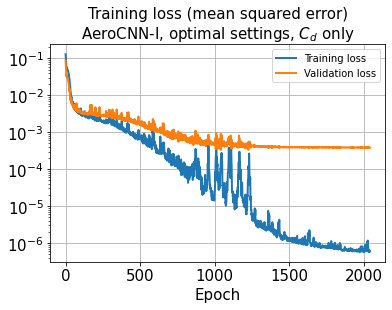

In [41]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

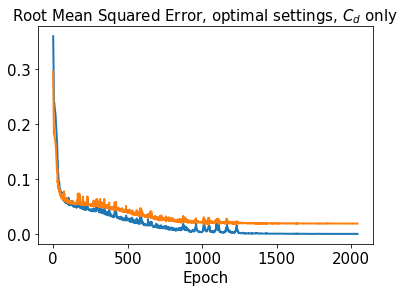

In [42]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

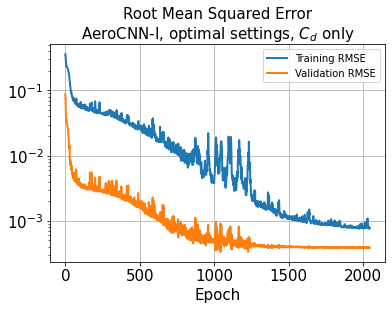

In [43]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [44]:
train_results = model.evaluate([x_train, x_para_train], y_train)

4/4 [==============================] - 0s 16ms/step - loss: 1.8407e-04 - rmse: 0.0136


In [45]:
test_results = model.evaluate([x_test, x_para_test], y_test)

1/1 [==============================] - 0s 65ms/step - loss: 2.3701e-04 - rmse: 0.0154


In [46]:
decoded_train_ = model.predict([x_train, x_para_train])
decoded_val_ = model.predict([x_val, x_para_val])
decoded_test_ = model.predict([x_test, x_para_test])

1/1 [==============================] - 0s 16ms/step


In [47]:
index_train = np.unique(np.where(np.isin(cd, y_train)))
index_val = np.unique(np.where(np.isin(cd, y_val)))
index_test = np.unique(np.where(np.isin(cd, y_test)))

In [48]:
y_train = y_train*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
y_val = y_val*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
y_test = y_test*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)

In [49]:
decoded_train = decoded_train_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
decoded_val = decoded_val_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
decoded_test = decoded_test_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)

In [50]:
model_directory = "D:\\TrainedModels\\20221205"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221205steadyValidation_AeroCNN1_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels) +"kernels_optimalSettings_Cdonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = np.abs(decoded_train - y_train)

In [52]:
error_val_abs = np.abs(decoded_val - y_val)

In [53]:
error_test_abs = np.abs(decoded_test - y_test)

In [54]:
os.chdir(storage_dir)

In [55]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.027251929236343512


In [56]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.03529021561993569


In [57]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.035857015790821054


In [58]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [59]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum((y_val[i]+1e-07)**2))
    l2_error_val_list.append(l2_error_val_data)

In [60]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

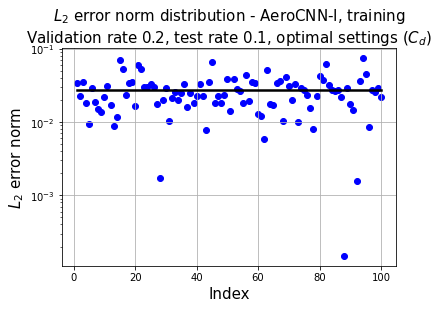

In [61]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, training\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

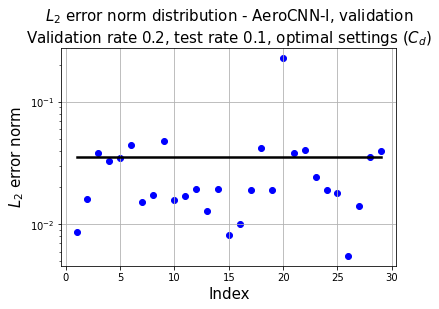

In [62]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, validation\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

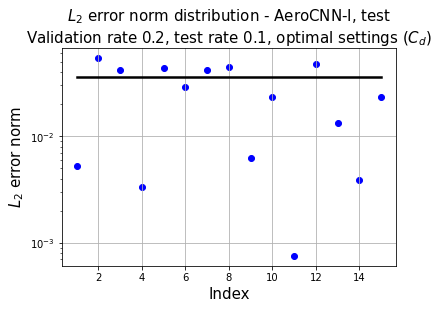

In [63]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-I, test\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict([x, x_para])

5/5 [==============================] - 0s 16ms/step


In [65]:
def CD_trainTestSplit_Plot(i, CD, cd, aTrain, aTest, iTrain, iTest):
    
    title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    #title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl
    
    title_n_Cd = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_D$ prediction, L2 error=%.4f'%(l2_error_Cd)
    #title_n_Cl = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_L$ prediction, L2 error=%.4f'%(l2_error_Cl)
    
    if i==0:
#         title_Cd, title_Cl = title_0_Cd, title_0_Cl
#         savename1,savename2 = "CdComparison_NACA0018.jpg", "ClComparison_NACA0018.jpg"
        title_Cd = title_0_Cd
        savename1 = "CdComparison_NACA0018.jpg"
    else:
#         title_Cd, title_Cl = title_n_Cd, title_n_Cl
        title_Cd = title_n_Cd
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
#         savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

    '''# CL graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig), color='b', label='Training set')
    plt.scatter(aTest, iTest[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()'''

1/1 [==============================] - 0s 58ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cd: 0.0337


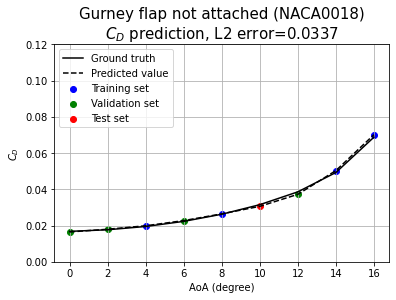

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0505


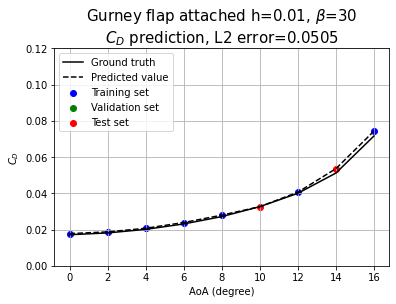

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0381


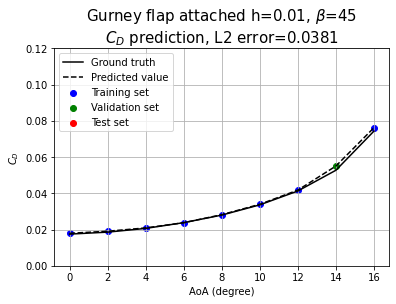

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0496


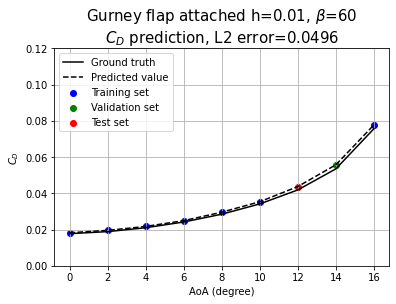

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0518


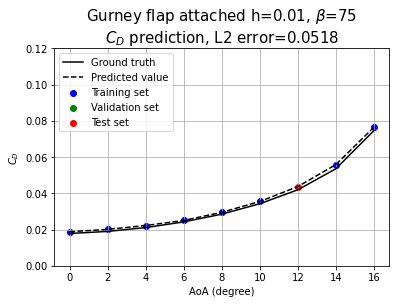

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0461


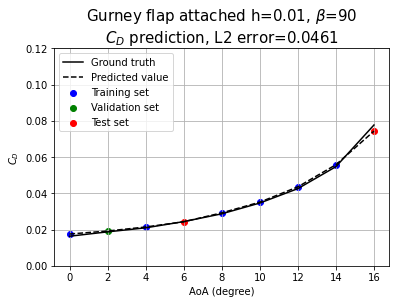

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0383


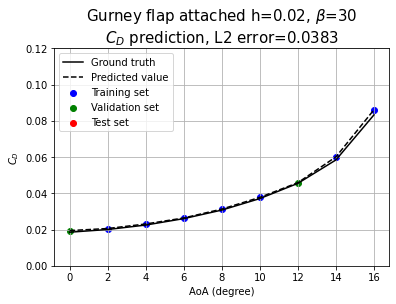

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0359


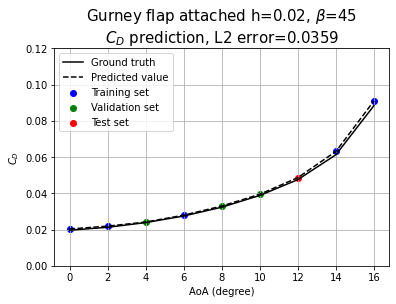

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0239


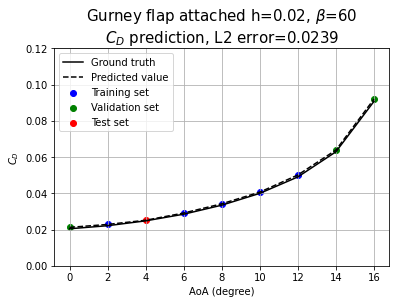

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0456


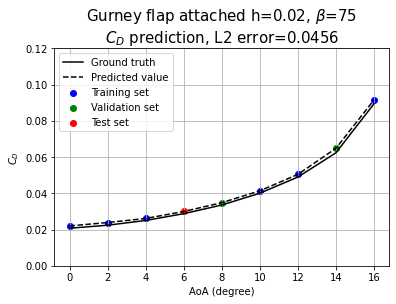

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0386


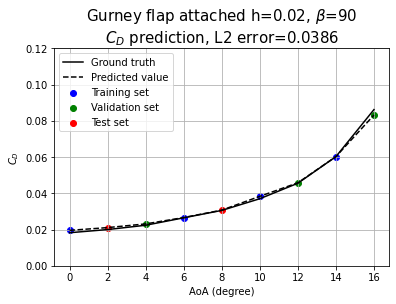

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0406


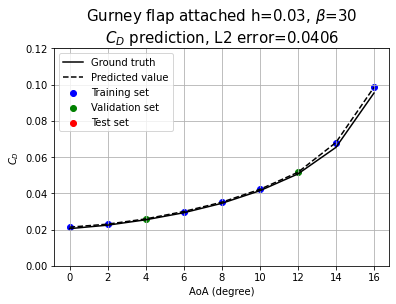

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0336


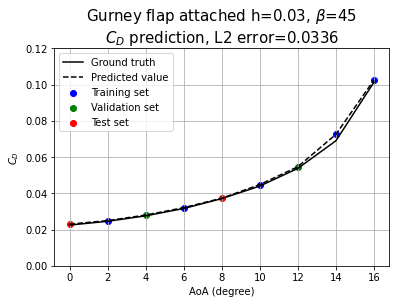

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0227


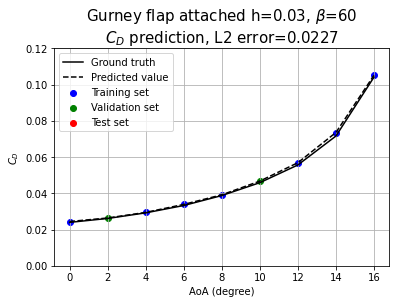

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0333


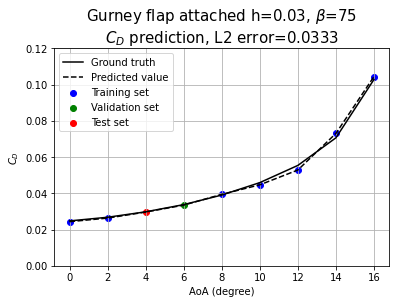

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0790


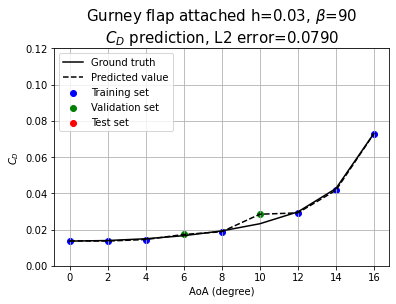

In [66]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    predictedValue = model.predict([x[n_alpha*i:n_alpha*(i+1),:],x_para[n_alpha*i:n_alpha*(i+1),:]])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cd = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}'.format(l2_error_Cd))
    else:
        print('L2 error of Cd: {0:0.4f}'.format(l2_error_Cd))
    
    cd = predicted[n_alpha*i:n_alpha*(i+1)]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    CD = y[n_alpha*i:n_alpha*(i+1)]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal.append(predicted[index])    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    iTest = np.array(iTest)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    iVal = np.array(iVal)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)*np.max(alpha)
    aVal = np.array(alpha_val)*np.max(alpha)
    aTest = np.array(alpha_test)*np.max(alpha)
    
    CD_trainTestSplit_Plot(i, CD, cd, aTrain, aTest, iTrain, iTest)